# 2. Photometric redshifts of galaxies

## 1b) 
The early work on photometric redshifts was done using linear regression. Design a regression estimator using either ridge, LASSO or linear regression to predict photometric redshifts, make sure to justify all the choises you make. Use the whole of file A for training and aim to obtain E($\theta$) < 0.01 as training error

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io.votable import parse_single_table
from astroML.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns
import pandas as pd

%matplotlib inline

In [3]:
# Read the document

#root = "/home/esmee/Documents/DBDM/DDM2017-master/FinalProject/"
root = "/disks/strw9/stoop/DBDM/DDM2017-master/FinalProject/Final-Project-DBDM/"
tableA = parse_single_table(root + "PhotoZFileA.vot")

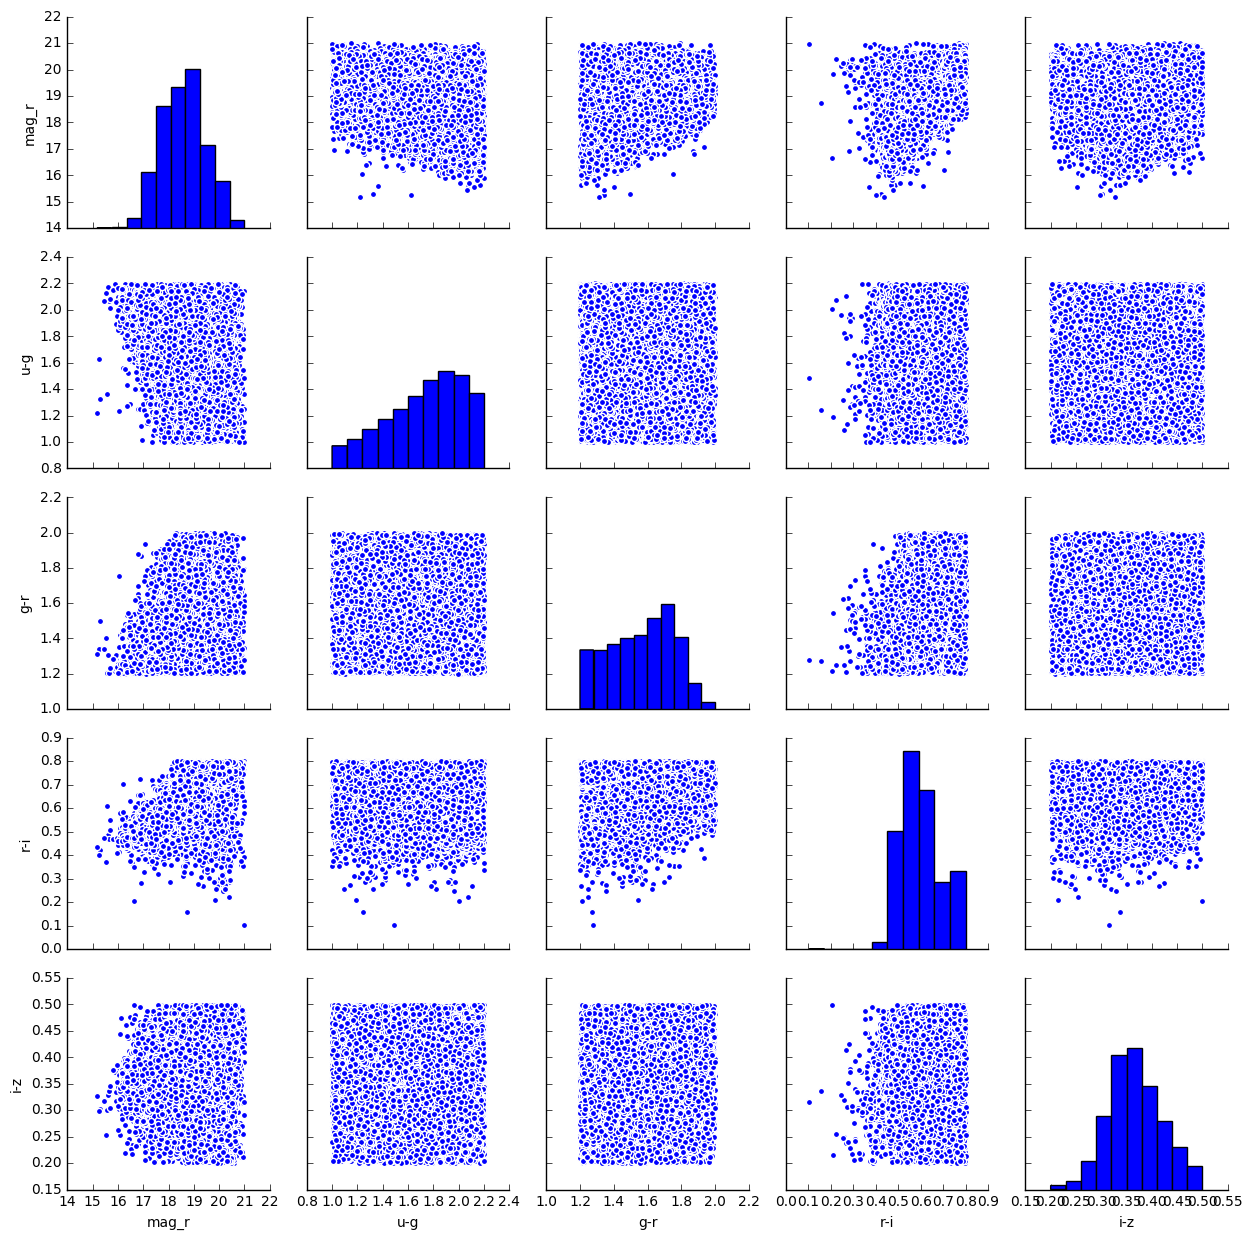

In [4]:
colnames = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']

Xa = np.vstack((tableA.array['mag_r'], tableA.array['u-g'], tableA.array['g-r'], tableA.array['r-i'], tableA.array['i-z'])).T
ya = tableA.array['z_spec']

g = sns.pairplot(pd.DataFrame(Xa, columns=colnames))

In [5]:
def predict( X, y, model = 'Linear'):
    if model == 'Linear':
        model = LinearRegression(fit_intercept=True)
    if model == 'Ridge':
        model = Ridge(alpha=0.05,fit_intercept=True, normalize=True)
    if model == 'Lasso':
        model = Lasso(alpha=0.05,fit_intercept=True, normalize=True)
    
    res = model.fit(X, y)
    pred = res.predict(X)
    
    return res, pred


def E(y_pred, y):
    err = np.median(np.abs( (y-y_pred) / (1+y)))
    print "Found error: {0:.4f}".format(err)
    return err

In [7]:
# Predict and find the discrepancy 

print "\nLinear Regression:"
res1, pred1 = predict(Xa,ya, model='Linear')
print "Z = {0:.3f} + {1:.3f}(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(res1.coef_[0],res1.coef_[1], res1.coef_[2], res1.coef_[3], res1.coef_[4], res1.coef_[5])    
e1 = E(pred1, ya)

print "\nLasso:"
res2, pred2 = predict(Xa,ya, model='Lasso')
c2 = [res2.intercept_]
[c2.append(coeff) for coeff in res2.coef_]
print "Z = {0:.3f} + {1:.3f}(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(c2[0],c2[1], c2[2], c2[3], c2[4], c2[5])
e2 = E(pred2, ya)

print "\nRidge:"
res3, pred3 = predict(Xa,ya, model='Ridge')
c3 = [res3.intercept_]
[c3.append(coeff) for coeff in res3.coef_]
print "Z = {0:.3f} + {1:.3f}(mag_r) + {2:.3f}(u-g) + {3:.3f}(g-r) + {4:.3f}(r-i) + {5:.3f}(i-z)".format(c3[0],c3[1], c3[2], c3[3], c3[4], c3[5])
e3 = E(pred3, ya)


Linear Regression:
Z = -0.783 + 0.040(mag_r) + -0.013(u-g) + 0.083(g-r) + 0.416(r-i) + 0.021(i-z)
Found error: 0.0146

Lasso:
Z = 0.323 + 0.000(mag_r) + -0.000(u-g) + 0.000(g-r) + 0.000(r-i) + 0.000(i-z)
Found error: 0.0503

Ridge:
Z = -0.756 + 0.039(mag_r) + -0.014(u-g) + 0.084(g-r) + 0.399(r-i) + 0.031(i-z)
Found error: 0.0146


/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


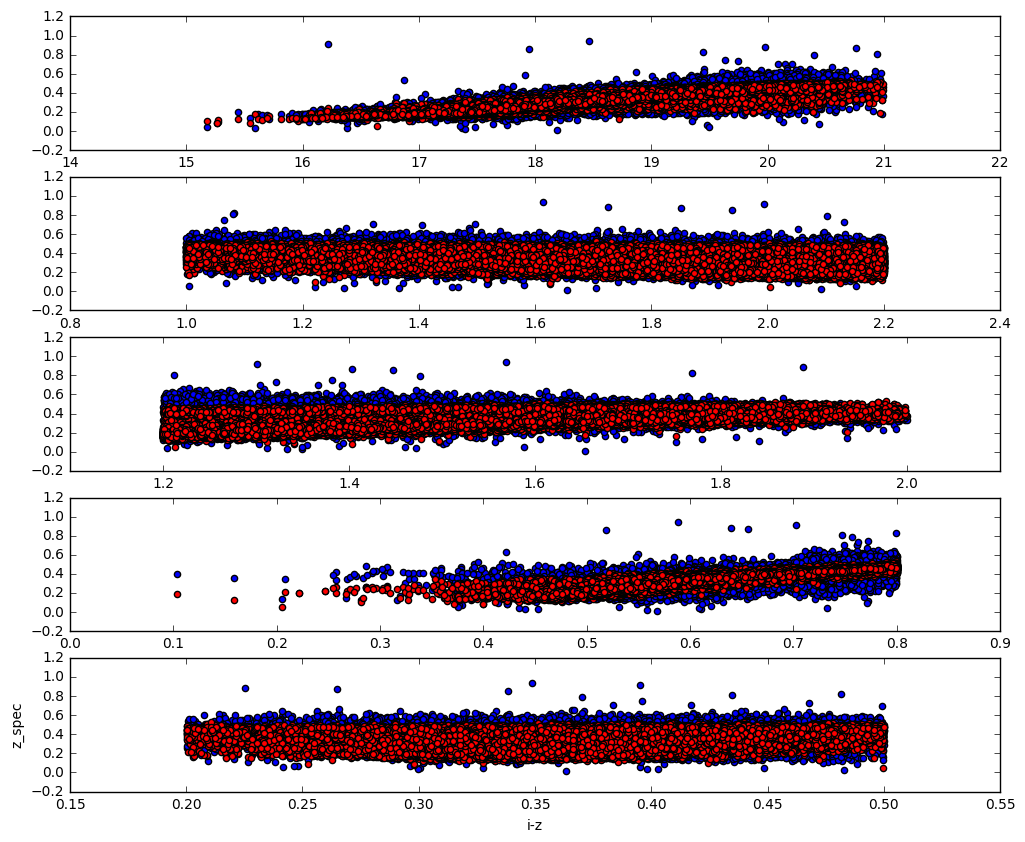

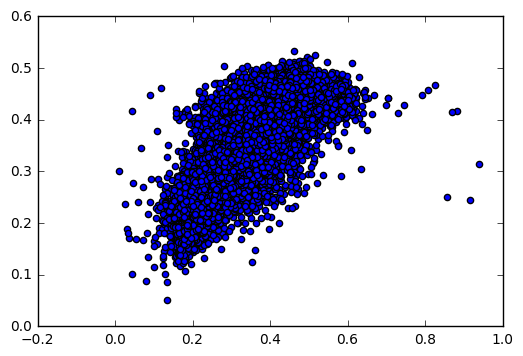

In [25]:
fig, ax = plt.subplots(5, figsize=(12,10))
plt.ylabel('z_spec')
for i,col in enumerate(colnames):
    ax[i].scatter(Xa[:,i], ya, c='blue')
    ax[i].scatter(Xa[:,i], pred1, c='red')
    ax[i].set_xlabel(col)

fig = plt.figure()
plt.scatter(ya, pred1)

## 1c) 
Use file B to quantify the generalisation error of the estimator you derived in problem b.

In [6]:
# Read the document of table B

tableB = parse_single_table(root + "PhotoZFileB.vot")
Xb = np.vstack((tableB.array['mag_r'], tableB.array['u-g'], tableB.array['g-r'], tableB.array['r-i'], tableB.array['i-z'])).T
yb = tableB.array['z_spec']

Test set
Found error: 0.0146


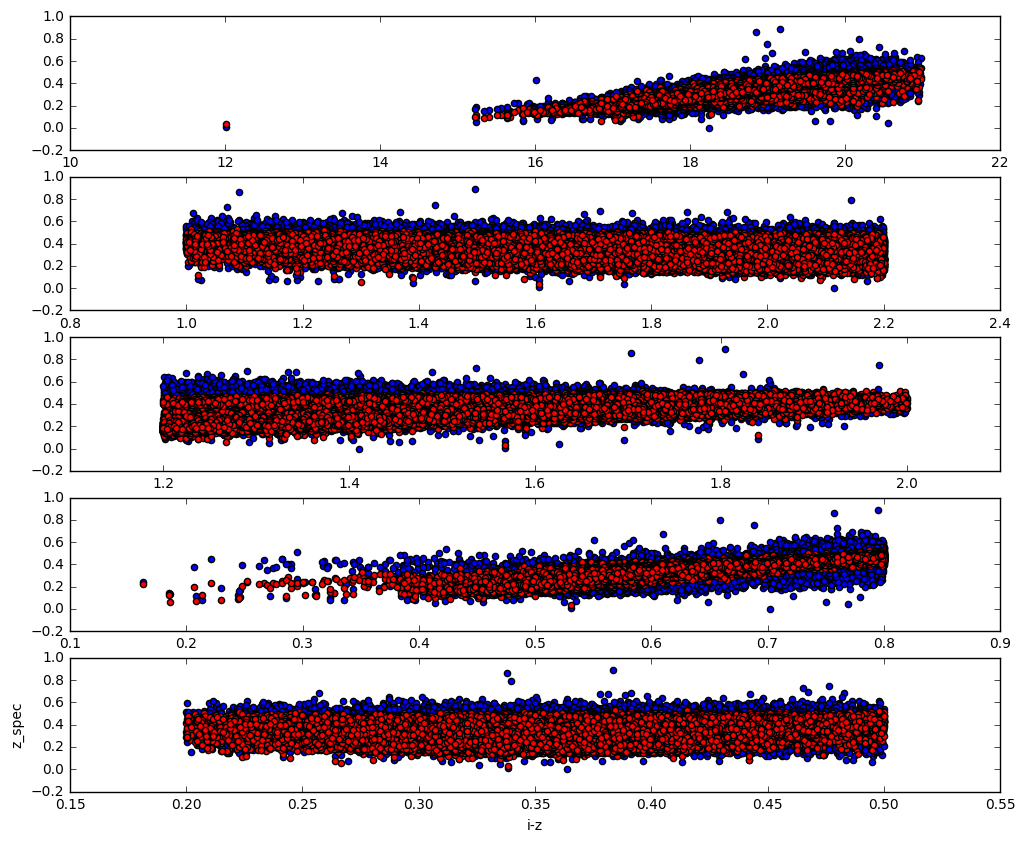

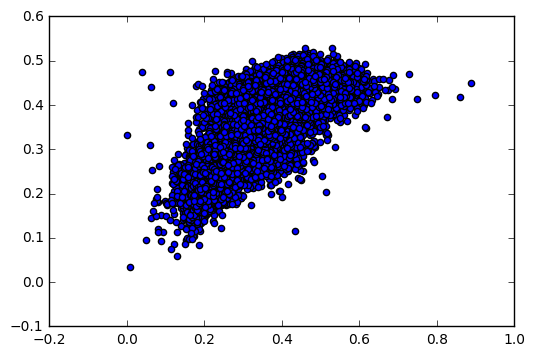

In [26]:
# Predict the test data

print "Test set"
er_test = E(res1.predict(Xb), yb)


fig, ax = plt.subplots(5, figsize=(12,10))
plt.ylabel('z_spec')
for i,col in enumerate(colnames):
    ax[i].scatter(Xb[:,i], yb, c='blue')
    ax[i].scatter(Xb[:,i], res1.predict(Xb), c='red')
    ax[i].set_xlabel(col)

fig = plt.figure()
plt.scatter(yb, res1.predict(Xb))

## 1d)
Implement a photo-z estimator using the method of your choice from any of the regression methods
discussed in the course, excluding the linear regression methods, e.g. k-nearest neighbours,
random forests, neural networks, boosting methods, but aim to get a lower generalisation error
than your method derived in problem b.

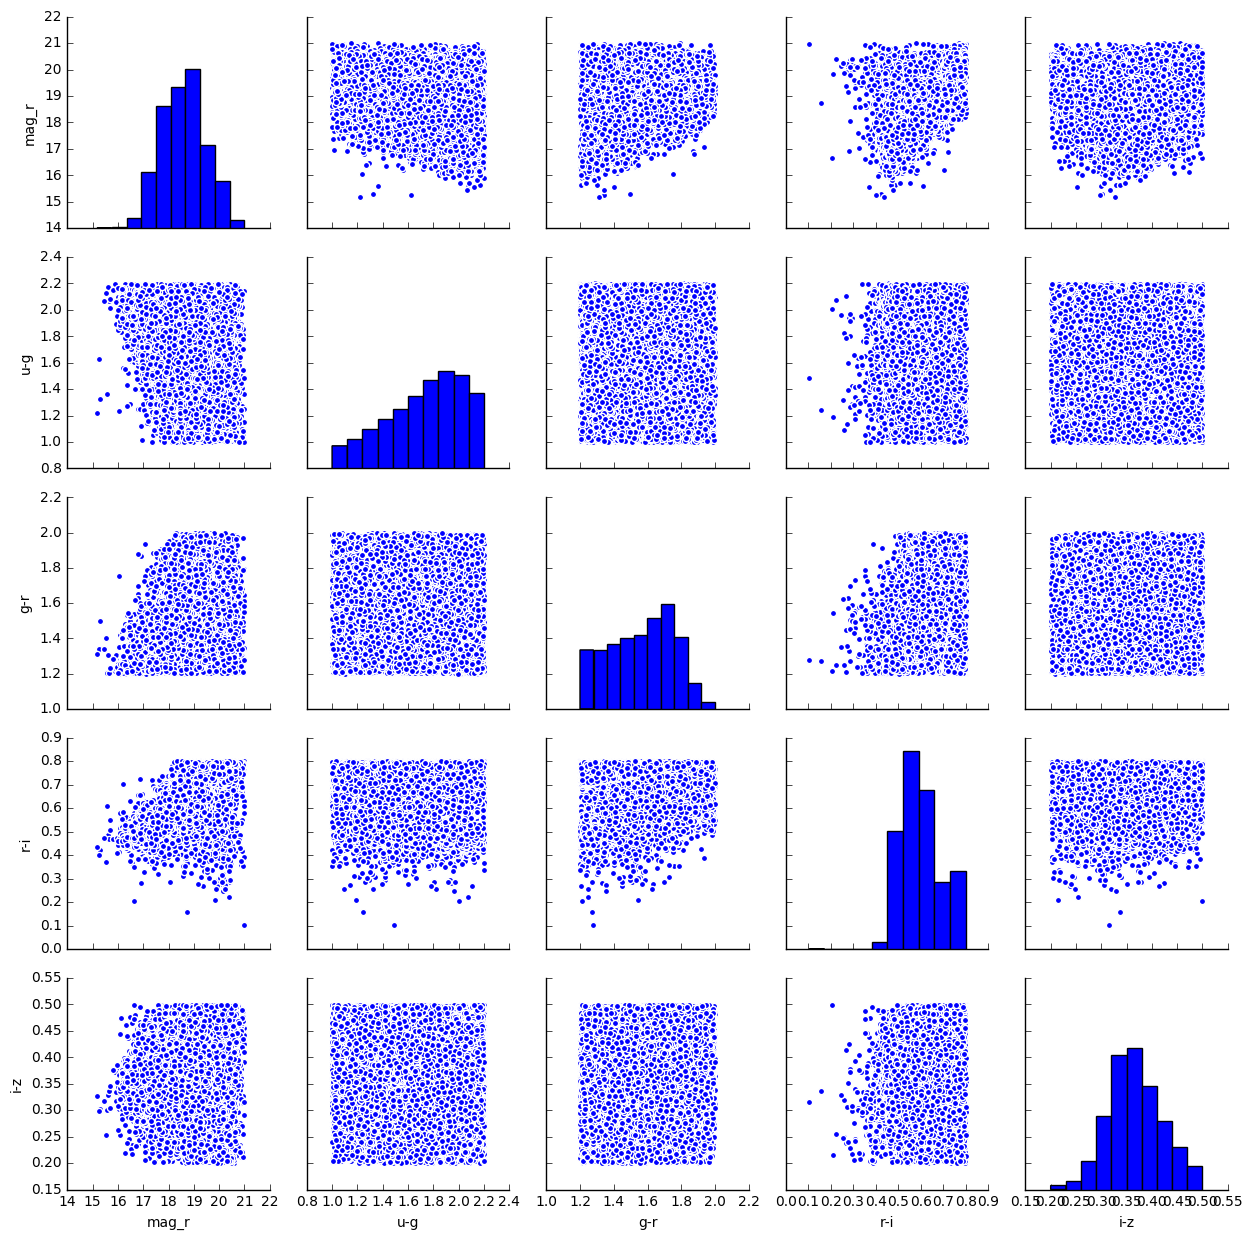

In [7]:
dft_5D = pd.DataFrame(Xa, columns=colnames)
dft_b = pd.DataFrame(Xb, columns = colnames)
sns.pairplot(dft_5D)

### Neural Network:

In [8]:
# Try a neural network without splitting the train data 
# Use the full dataset in 5D

from sklearn.neural_network import MLPRegressor as nn

# Turn the data into tuples
X_train = [tuple(x) for x in dft_5D.to_records(index=False)]
y_train = list(ya)

X_test = [tuple(x) for x in dft_b.to_records(index=False)]
y_test = list(yb)


In [9]:
# Search for the best combination of layers

lay2 = np.arange(1, 20, 2)
lay3 = np.arange(1, 20, 2)


params = [0, 0, 0] # lay2, lay3
best_e = np.inf

e_test = []
e_train = []


for i, l2 in enumerate(lay2):
    e_test_loc = []
    e_train_loc = []
    for m, l3 in enumerate(lay3):
        print "layers:",l2,l3, "\n-------------------"

        mlp = nn(hidden_layer_sizes=(5, l2, l3, 1))
        mlp.fit(X_train, y_train)
        
        pred_train = mlp.predict(X_train)
        pred_test = mlp.predict(X_test)
        
        e = E(pred_train, ya)
        
        e_train_loc.append(e)
        e_test_loc.append(E(pred_test, yb))
        
        if e < best_e:
            params = [l2, l3]
            best_e = e
            best_mlp = mlp
    
    e_train.append((l2, l3, e_train_loc))
    e_test.append((l2, l3,e_test_loc))

print "Beste value found: ", best_e 
print "lay2 = {0}, lay3 = {1}".format(params[0], params[1])

layers: 1 1 
-------------------


/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Found error: 0.0503
Found error: 0.0499
layers: 1 3 
-------------------
Found error: 0.0150
Found error: 0.0151
layers: 1 5 
-------------------
Found error: 0.0504
Found error: 0.0499
layers: 1 7 
-------------------
Found error: 0.0503
Found error: 0.0499
layers: 1 9 
-------------------
Found error: 0.0145
Found error: 0.0146
layers: 1 11 
-------------------
Found error: 0.0504
Found error: 0.0499
layers: 1 13 
-------------------
Found error: 0.0503
Found error: 0.0499
layers: 1 15 
-------------------
Found error: 0.0504
Found error: 0.0499
layers: 1 17 
-------------------
Found error: 0.0502
Found error: 0.0498
layers: 1 19 
-------------------
Found error: 0.0503
Found error: 0.0498
layers: 3 1 
-------------------
Found error: 0.0504
Found error: 0.0499
layers: 3 3 
-------------------
Found error: 0.0503
Found error: 0.0499
layers: 3 5 
-------------------
Found error: 0.0503
Found error: 0.0499
layers: 3 7 
-------------------
Found error: 0.0503
Found error: 0.0499
layers

In [10]:
pred_test = best_mlp.predict(X_test)
E(pred_test, yb)

Found error: 0.0142


0.01422643683076435

### k-nearest neighbours regression:

In [146]:
from sklearn.neighbors import KNeighborsRegressor


def knn_regress(X, y, x_pred=None, k=5, alg = 'auto', boost=False):
    if boost:
        neigh = AdaBoostRegressor(KNeighborsRegressor(n_neighbors=k, algorithm = alg), n_estimators = 100)
    else:
        neigh = KNeighborsRegressor(n_neighbors=k, algorithm = alg)
    
    neigh.fit(X,y)
    
    y_hat = []
    for x in x_pred:
        y_hat.append(neigh.predict(x))
    
    return y_hat
    

In [153]:
#e_train, e_test = [], []

for k in range(20,50):
    print k, "\n-------"
    y_pred = knn_regress(dft_5D, ya, x_pred=[dft_5D, dft_b], k=k, alg = 'ball_tree')
    e_train.append(E(y_pred[0], ya))
    e_test.append(E(y_pred[1], yb))

20 
-------
Found error: 0.0117
Found error: 0.0124
21 
-------
Found error: 0.0117
Found error: 0.0124
22 
-------
Found error: 0.0118
Found error: 0.0125
23 
-------
Found error: 0.0118
Found error: 0.0125
24 
-------
Found error: 0.0118
Found error: 0.0125
25 
-------
Found error: 0.0118
Found error: 0.0125
26 
-------
Found error: 0.0118
Found error: 0.0125
27 
-------
Found error: 0.0119
Found error: 0.0125
28 
-------
Found error: 0.0119
Found error: 0.0125
29 
-------
Found error: 0.0119
Found error: 0.0125
30 
-------
Found error: 0.0119
Found error: 0.0125
31 
-------
Found error: 0.0119
Found error: 0.0125
32 
-------
Found error: 0.0120
Found error: 0.0125
33 
-------
Found error: 0.0120
Found error: 0.0125
34 
-------
Found error: 0.0120
Found error: 0.0125
35 
-------
Found error: 0.0120
Found error: 0.0125
36 
-------
Found error: 0.0120
Found error: 0.0125
37 
-------
Found error: 0.0120
Found error: 0.0125
38 
-------
Found error: 0.0121
Found error: 0.0125
39 
-------


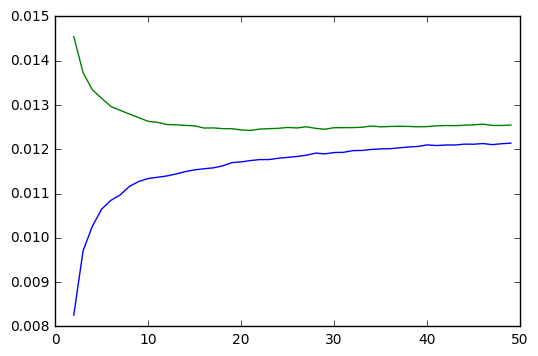

In [154]:
plt.plot(range(2,50), e_train) 
plt.plot(range(2,50), e_test)

### Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [30]:
def random_forest(X,y, x_pred, depth=2, n_estimators=10, boost = False):
    '''Makes prediction for x_pred data using a random forest 
    
    Parameters
    -----------
    X,y    = data to fit on with y the labels
    x_pred = data for which to make the predictions checks for multiple sizes
    depth  = depth of the decision three
    n_estimators = number of estimators in the tree
    boost  = whether to use the boost for the data. True or False
    
    Output
    ------
    y_hat  = predicted values for x_pred. Has the same size as x_pred
    '''
    #Use boost
    if boost:
        regr = AdaBoostRegressor(RandomForestRegressor(max_depth=depth, random_state=0, 
                                n_estimators=n_estimators), n_estimators = 100)
    else:
        regr = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=n_estimators)
    
    #Fit the data
    regr.fit(X,y)
    
    #Check for length of x_pred and give the predictions
    if len(x_pred) == 1:
        y_hat = regr.predict(x_pred)
    else:
        y_hat = []
        for x in x_pred:
            y_hat.append(regr.predict(x))
    
    return y_hat

In [33]:
e_train = []
e_test = []
for d in range(1,10):
    print d,"\n-------"
    y_pred = random_forest(dft_5D, ya, x_pred=[dft_5D, dft_b], depth=d, n_estimators = 10, boost = True)
    e_train.append(E(y_pred[0], ya))
    e_test.append(E(y_pred[1], yb))
        

1 
-------
Found error: 0.0307
Found error: 0.0308
2 
-------
Found error: 0.0216
Found error: 0.0217
3 
-------
Found error: 0.0179
Found error: 0.0179
4 
-------
Found error: 0.0181
Found error: 0.0181
5 
-------
Found error: 0.0196
Found error: 0.0197
6 
-------
Found error: 0.0173
Found error: 0.0175
7 
-------
Found error: 0.0134
Found error: 0.0136
8 
-------
Found error: 0.0160
Found error: 0.0160
9 
-------
Found error: 0.0160
Found error: 0.0161


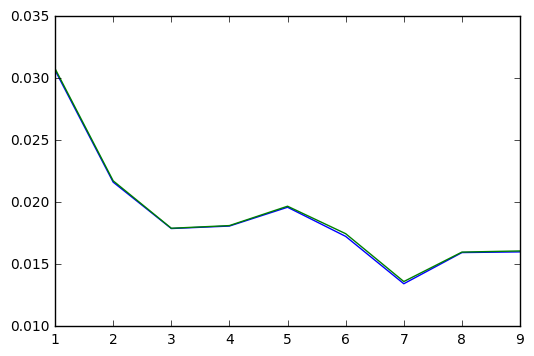

In [35]:


plt.plot(range(1,10), e_train)
plt.plot(range(1,10), e_test)

### Kernel Ridge Regression

In [56]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_validation import KFold


In [135]:
def KernelRegression(X,y, x_pred, boost = False):
    if boost:
        clf = AdaBoostRegressor(KernelRidge(alpha=1.0), n_estimators=100)
    else:
        clf = KernelRidge(alpha=1.0)
    
    clf.fit(X,y)
    
    if len(x_pred) == 1:
        y_hat = clf.predict(x_pred)
    else:
        y_hat = []
        for x in x_pred:
            y_hat.append(clf.predict(x))

    return y_hat



dft_tot = pd.DataFrame([], columns=colnames)
dft_tot = dft_tot.append(dft_5D)
dft_tot = dft_tot.append(dft_b)
y_tot = []
y_tot.extend(ya)
y_tot.extend(yb)
y_tot = np.array(y_tot)
kf = KFold(n = len(y_tot), n_folds=4e3)

e_train, e_test = [], []
e_train_boost, e_test_boost = [], [] 

for train, test in kf:
    x_train, y_train = dft_tot.values[train, :], y_tot[train]
    x_test, y_test = dft_tot.values[test, :], y_tot[test]
    
    y_pred = KernelRegression(x_train,y_train, [x_train, x_test], boost = False)
    y_pred_boost = KernelRegression(x_train,y_train, [x_train, x_test], boost = True)
    print "train"
    e_train.append(E(y_pred[0], y_train))
    print "test"
    e_test.append(E(y_pred[1], y_test))
    print "train_boost"
    e_train_boost.append(E(y_pred_boost[0], y_train))
    print "test_boost"
    e_test_boost.append(E(y_pred_boost[1], y_test))
    
print np.mean(e_train), np.mean(e_test)
print np.mean(e_train_boost), np.nanmean(e_test_boost)

"""#y_pred_boost = KernelRegression(dft_5D,ya, [dft_5D, dft_b], boost = True)
y_pred = KernelRegression(dft_5D,ya, [dft_5D, dft_b], boost = False)


#print "Boost"
#E(y_pred_boost[0], ya)
#E(y_pred_boost[1], yb)

print "Normal"
E(y_pred[0], ya)
E(y_pred[1], yb)"""

MemoryError: 

In [134]:
len(y_tot)/2e3

74.433

(74309, 5)

(148866, 5)